## GPU usage

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import time
from keras.datasets import mnist
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
import keras as k

In [ ]:
print(tf.__version__)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
tf.config.list_physical_devices()

In [ ]:
print(device_lib.list_local_devices())

In [ ]:
#data preprocessing
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28,28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_test=x_test.astype('float32')
x_train=x_train.astype('float32')
mean=np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std
x_train = (x_train-mean)/std

print("counts of x_train : {}, y_train : {}, x_test : {}, y_test : {}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))

In [ ]:
#labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)
print("counts of x_train : {}, y_train : {}, x_test : {}, y_test : {}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))

In [ ]:
num_filter=16 # 32
num_dense=256 # 512
drop_dense=0.7
ac='relu'
learningrate=0.01

def create_model():
    model = Sequential()

    model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

    model.add(Flatten())                        
    model.add(Dense(num_dense, activation=ac))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(10, activation='softmax'))

    adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)

    return model

In [ ]:
batch_sizes = [256, 128, 64, 32, 16]

In [ ]:
cpu_list=[]
with tf.device("/cpu:0"):
    for batch_size in batch_sizes:
        model = create_model()
        print("batch size "+str(batch_size))
        t1 = time.time()
        model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_data=(x_test, y_test))
        t2 = time.time()
        cpu_list.append(int(t2-t1))

print("cpu_list : ", cpu_list)

In [ ]:
gpu_list=[]
with tf.device("/gpu:0"):
    for batch_size in batch_sizes:
        model = create_model()
        print("batch size "+str(batch_size))
        t1 = time.time()
        model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_data=(x_test, y_test))
        t2 = time.time()
        gpu_list.append(int(t2-t1))

print("gpu_list : ", gpu_list)

In [ ]:
#cpu_list = [128, 142, 193, 234, 261]
#gpu_list = [8, 12, 19, 33, 59]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(batch_sizes, cpu_list, label="cpu")
plt.plot(batch_sizes, gpu_list, label="gpu")
plt.xlabel("Batch sizes")
plt.ylabel("Time (s)")
plt.title("CPU vs GPU time usage", fontsize=14)
plt.legend()
plt.show()

## Imports

In [1]:
import pandas as pd
import numpy as np
import open3d as o3d
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score

from copy import deepcopy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
VAL_SPLIT = 0.1 # 10%
TEST_SPLIT = 0.1 # 10%
STATISTICS = ["median", "std", "max", "min"]
CELL_SIZE = 0.5 # 0.5 meters
Z_INDEX = 3

## Read the data

In [3]:
# Read data
data = pd.read_csv("data/felt1_points.csv")
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

In [20]:
data.head(10)

,accepted,x,y,z,thu,tvu
0,1.0,0.00,9.21,19.53,0.09,0.12
1,1.0,0.00,9.22,19.48,0.08,0.12
2,1.0,0.00,9.53,19.52,0.09,0.12
3,1.0,0.01,9.43,19.51,0.07,0.12
4,1.0,0.02,9.41,19.48,0.08,0.12
5,1.0,0.03,9.58,19.50,0.08,0.12
6,1.0,0.03,9.61,19.59,0.08,0.12
7,1.0,0.04,9.19,19.45,0.08,0.12
8,1.0,0.04,9.73,19.53,0.08,0.12
9,1.0,0.04,9.78,19.55,0.09,0.12


## Select area

In [4]:
def area_of_dataframe(dataframe, x_start, x_last, y_start, y_last):
    area_dataframe = dataframe[
        (dataframe["x"] >= x_start) &
        (dataframe["x"] < x_last) & 
        (dataframe["y"] >= y_start) & 
        (dataframe["y"] < y_last)
    ]
    return area_dataframe

In [5]:
# Pick an area
xStart = np.min(data.x)+0 # Start meter x
yStart = np.min(data.y)+0 # Start meter y
area = 25
data_area = area_of_dataframe(data, xStart, xStart+area, yStart, yStart+area)
len(data_area)

141619

In [6]:
len(data_area[data_area.accepted == 0]) / len(data_area[data_area.accepted == 1])

0.14409086869764023

## Visualize

In [6]:
def visualize_area(data_area, voxel_size=0.02):
    _x = np.array(data_area.x)
    _y = np.array(data_area.y)
    _z = np.array(data_area.z)

    _red = np.array(np.zeros(len(data_area.x)))
    _green = np.array(np.zeros(len(data_area.x)))
    _blue = np.array(np.zeros(len(data_area.x)))

    acceptance = np.array(data_area.accepted)
    for idx, val in enumerate(acceptance):
        
        if val > 0:
            _green[idx] = 65535
        else:
            _red[idx] = 65535

    pcd = o3d.geometry.PointCloud()

    pcd.points = o3d.utility.Vector3dVector(np.vstack((_x, _y, _z)).transpose())
    pcd.colors = o3d.utility.Vector3dVector(np.vstack((_red, _green, _blue)).transpose()/65535)

    voxel_grid=o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)

    o3d.visualization.draw_geometries([voxel_grid])

In [8]:
visualize_area(data_area, voxel_size=0.05)

## Dataframe to normalized cells

In [9]:
def cell_statistics(cell, z_index):
    cell_z = cell[:, z_index]
    median = np.median(cell_z)
    std = np.std(cell_z)
    mx = np.max(cell_z)
    mn = np.min(cell_z)

    return median, std, mx, mn

In [10]:
def dataframe_to_normalized_stats_cells(dataframe, cells_in_x, cells_in_y, MinMaxArea, z_index):
    cells = []
    visualize_cell = []

    sample_min = np.min(MinMaxArea, axis=0)
    sample_max = np.max(MinMaxArea, axis=0)

    for ix, x in enumerate(cells_in_x):
        for iy, y in enumerate(cells_in_y):
            if ix != 0 and iy != 0:
                cell = np.array(area_of_dataframe(dataframe, cells_in_x[ix-1], x, cells_in_y[iy-1], y)) 
                visualize_cell.append(cell)            

                if len(cell) <= 0:
                    cells.append(cell)
                else:
                    # Normalize
                    norm_cell = (cell - sample_min) / (sample_max - sample_min)
                    
                    # Add cell statistics
                    median, std, mx, mn = cell_statistics(norm_cell, z_index)
                    stats = np.array([[median, std, mx, mn] for i in range(len(norm_cell))])
                    norm_cell_stats = np.append(norm_cell, stats, axis=1)

                    cells.append(norm_cell_stats)
    
    return cells, visualize_cell

In [11]:
# Turn area into cells
cells_in_x = np.arange(data_area.x.min(), data_area.x.max()+CELL_SIZE, CELL_SIZE)
cells_in_y = np.arange(data_area.y.min(), data_area.y.max()+CELL_SIZE, CELL_SIZE)
cells, visualize_cells = dataframe_to_normalized_stats_cells(data_area, cells_in_x, cells_in_y, np.array(data), Z_INDEX)

In [12]:
print(len(cells))
print(len(visualize_cells))

1700
1700


## Find cell neighbors

In [12]:
def check_neighbor(all_stats, current_cell, len_stats):
    if len(current_cell) <= 0:
        return np.concatenate((all_stats, np.array([-1 for i in range(len_stats)])), axis=0)
    else:
        return np.concatenate((all_stats, current_cell[0, -len_stats:]), axis=0)

In [13]:
def get_cell_neighbors(cells, cells_in_y, num_neighbors, len_stats, visualize_cells):
    num_cells_in_y = len(cells_in_y)-1
    neighbor_cells = []
    neighor_visualize_cells = []

    for cell_idx in range(len(cells)):
        if len(cells[cell_idx]) <= 0:
            continue

        if cell_idx < num_cells_in_y*num_neighbors or cell_idx >= len(cells)-num_cells_in_y*num_neighbors:
            continue # Continue on horizontal edges
        if (cell_idx % num_cells_in_y) < num_neighbors or (cell_idx % num_cells_in_y) >= num_cells_in_y-num_neighbors:
            continue # Continue on vertical edges

        all_neighbor_stats = np.array([])
        for nx in range(1, num_neighbors+1):
            all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx-(num_cells_in_y*nx))], len_stats) # Neighbors to the left
            all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx-nx)], len_stats) # Neighbors above
            all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx+nx)], len_stats) # Neighbors below
            all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx+(num_cells_in_y*nx))], len_stats) # Neighbors to the right
            for ny in range(1, num_neighbors+1):
                all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx-((num_cells_in_y*nx)+ny))], len_stats) # Left corners
                all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx-((num_cells_in_y*nx)-ny))], len_stats) # Left corners
                all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx+((num_cells_in_y*nx)-ny))], len_stats) # Right corners
                all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx+((num_cells_in_y*nx)+ny))], len_stats) # Right corners

        # Add stats to current cell
        stats = np.array([all_neighbor_stats for i in range(len(cells[cell_idx]))]) # np.concatenate instead?
        neighbor_cell_stats = np.append(cells[cell_idx], stats, axis=1)
        neighbor_cells.append(neighbor_cell_stats)
        neighor_visualize_cells.append(visualize_cells[cell_idx])

    return neighbor_cells, neighor_visualize_cells

In [19]:
visualize_cells.head(5)

AttributeError: 'list' object has no attribute 'head'

In [14]:
# Get neighbor cells for each cell
num_neighbors = 0
neighbors, neighbors_visualize = get_cell_neighbors(cells, cells_in_y, num_neighbors, len(STATISTICS), visualize_cells)
processed_data = np.concatenate(neighbors)
processed_data_visualize = np.concatenate(neighbors_visualize)

In [15]:
print(processed_data.shape)
print(processed_data_visualize.shape)

(141619, 10)
(141619, 6)


## Get train, val and test

In [16]:
X = processed_data[:, Z_INDEX:]
y = processed_data[:, 0]

X_visualize = processed_data_visualize[:, 1:4]
y_visualize = processed_data_visualize[:, 0]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=1)
_, X_test_visualize, _, y_test_visualize = train_test_split(X_visualize, y_visualize, test_size=TEST_SPLIT, random_state=1)

In [25]:
combine = np.concatenate((X_test_visualize, y_test_visualize.reshape(len(y_test_visualize), 1)), axis=1)
visualize_result = pd.DataFrame(combine, columns=["x", "y", "z", "accepted"])

In [27]:
visualize_area(visualize_result, voxel_size=0.07)

## Weights

In [28]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 3.960013670539986, 1: 0.5722540497826946}

## Training and test evaluation 

In [29]:
def plot_result(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and validation {} over epochs".format(item), fontsize=14)
    plt.legend()
    plt.show()

def evaluate_training(history):
    plot_result(history, "binary_accuracy")
    plot_result(history, "loss")

def evaluate(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return confusion, f1, accuracy, recall

def evaluate_testing(y_test, y_pred):
    confusion, f1, accuracy, recall = evaluate(y_test, y_pred)
    print("Confusion matrixes: ")
    print(confusion)
    print("\n")
    print("F1 score: " + str(np.round(np.mean(f1), 4)) + "\n")
    print("Accuracy score: " + str(np.round(np.mean(accuracy), 4)) + "\n")
    print("Recall score: " + str(np.round(np.mean(recall), 4)))

## Own cell model
- Small varied area -> 20m^2, batch_size=64
- Not alot of parameters, simple model -> 1 hidden layer, size=[16]

In [30]:
# Create model
model = keras.Sequential()
model.add(keras.layers.Input(shape=X_train[0].shape, name="Input"))
model.add(keras.layers.Dense(16, activation="relu", name="Hidden1"))
model.add(keras.layers.Dense(1, activation="sigmoid", name="Output"))
model.summary()

opt = keras.optimizers.Adam(0.0001) # learning_rate=1e-6
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, min_delta=0.01, patience=10) # Prevent overfitting

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 16)                128       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_split=VAL_SPLIT,
    class_weight=class_weight_dict,
    batch_size=64, # Default
    epochs=20,
    callbacks=[es],
    shuffle=True) # Default

Epoch 1/20
1793/1793 [==============================] - 20s 7ms/step - loss: 0.6884 - binary_accuracy: 0.4513 - val_loss: 0.6950 - val_binary_accuracy: 0.6394
Epoch 2/20
1793/1793 [==============================] - 13s 7ms/step - loss: 0.6797 - binary_accuracy: 0.6686 - val_loss: 0.6836 - val_binary_accuracy: 0.6597
Epoch 3/20
1793/1793 [==============================] - 13s 8ms/step - loss: 0.6705 - binary_accuracy: 0.7266 - val_loss: 0.6750 - val_binary_accuracy: 0.7088
Epoch 4/20
1793/1793 [==============================] - 13s 7ms/step - loss: 0.6604 - binary_accuracy: 0.7813 - val_loss: 0.6572 - val_binary_accuracy: 0.7868
Epoch 5/20
1793/1793 [==============================] - 13s 7ms/step - loss: 0.6497 - binary_accuracy: 0.7959 - val_loss: 0.6409 - val_binary_accuracy: 0.8003
Epoch 6/20
1793/1793 [==============================] - 13s 8ms/step - loss: 0.6392 - binary_accuracy: 0.8031 - val_loss: 0.6338 - val_binary_accuracy: 0.8000
Epoch 7/20
1793/1793 [========================

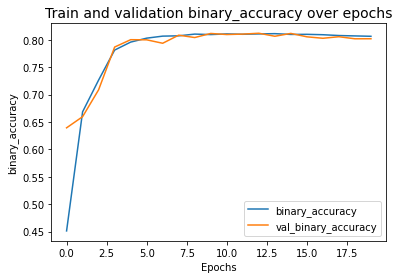

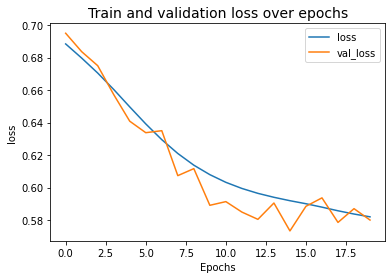

443/443 [==============================] - 1s 2ms/step
Confusion matrixes: 
[[ 1005   738]
 [ 1995 10424]]


F1 score: 0.8841

Accuracy score: 0.807

Recall score: 0.8394


In [32]:
# Training
evaluate_training(history)

# Testing
test_loss, test_acc = model.evaluate(X_test, y_test)
prediction = model.predict(X_test)
evaluate_testing(y_test, prediction.round())

In [33]:
combine = np.concatenate((X_test_visualize, prediction.round()), axis=1)
visualize_result = pd.DataFrame(combine, columns=["x", "y", "z", "accepted"])
visualize_area(visualize_result)

In [34]:
visualize_area(visualize_result, voxel_size=0.07)

In [36]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction)

In [ ]:
# Using recall and precision at thresholds for optimal f2 scores
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

In [ ]:
alt_threshold_prediction = np.where(prediction > thresholds[ix], 1, 0)
evaluate_testing(y_test, alt_threshold_prediction)

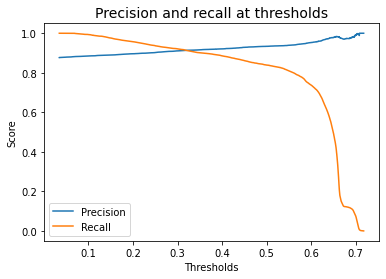

In [38]:
# Using recall and precision at thresholds to find the middle ground for both
plt.plot(thresholds, precision[0:-1], label="Precision")
plt.plot(thresholds, recall[0:-1], label="Recall")
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.legend()
plt.title("Precision and recall at thresholds", fontsize=14)
plt.show()

In [ ]:
# Visualize data
alt_threshold_prediction = np.where(prediction > 0.35, 1, 0)
evaluate_testing(y_test, alt_threshold_prediction)
combine = np.concatenate((X_vis, alt_threshold_prediction), axis=1)
visualize_result = pd.DataFrame(combine, columns=["x", "y", "z", "accepted"])

In [ ]:
# Visualize
visualize_area(visualize_result, voxel_size=0.002)

In [ ]:
# Should have
res_y = y_test.reshape((len(y_test), 1))
combine = np.concatenate((X_vis, res_y), axis=1)
visualize_result = pd.DataFrame(combine, columns=["x", "y", "z", "accepted"])
visualize_area(visualize_result, voxel_size=0.05)

In [ ]:
visualize_area(data_area)

## Neighbor cells
- 2 neighbors, 1m around each point
- Add a couple of meters to the data to compansate for neighbors -> 22m^2, batch_size=64
- More complex, hence another layer -> 2 layers, size=[128, 64]

In [50]:
num_neighbors = 4
neighbors, neighbors_visualize = get_cell_neighbors(cells, cells_in_y, num_neighbors, len(STATISTICS), visualize_cells)
processed_data = np.concatenate(neighbors)
processed_data_visualize = np.concatenate(neighbors_visualize)

X = processed_data[:, Z_INDEX:]
y = processed_data[:, 0]
X_visualize = processed_data_visualize[:, 1:4]
y_visualize = processed_data_visualize[:, 0]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=TEST_SPLIT, random_state=1)
_, X_test_visualize2, _, _ = train_test_split(X_visualize, y_visualize, test_size=TEST_SPLIT, random_state=1)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train2), y=y_train2)
class_weight_dict = dict(enumerate(class_weights))


# Create model
model = keras.Sequential()
model.add(keras.layers.Input(shape=X_train2[0].shape, name="Input"))
model.add(keras.layers.Dense(256, activation="relu", name="Hidden1"))
model.add(keras.layers.Dense(128, activation="relu", name="Hidden2"))
model.add(keras.layers.Dense(64, activation="relu", name="Hidden3"))
model.add(keras.layers.Dense(1, activation="sigmoid", name="Output"))
model.summary()

opt = keras.optimizers.Adam(0.000001) # learning_rate=1e-6
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, min_delta=0.01, patience=10) # Prevent overfitting

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 256)               83968     
                                                                 
 Hidden2 (Dense)             (None, 128)               32896     
                                                                 
 Hidden3 (Dense)             (None, 64)                8256      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 125,185
Trainable params: 125,185
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Train the model
history2 = model.fit(
    X_train2, 
    y_train2, 
    validation_split=VAL_SPLIT, 
    class_weight=class_weight_dict,
    batch_size=64, # Default
    epochs=20,
    callbacks=[es],
    shuffle=True) # Default

Epoch 1/20
1188/1188 [==============================] - 10s 8ms/step - loss: 0.6843 - binary_accuracy: 0.1536 - val_loss: 0.7168 - val_binary_accuracy: 0.1620
Epoch 2/20
1188/1188 [==============================] - 9s 8ms/step - loss: 0.6719 - binary_accuracy: 0.3669 - val_loss: 0.6952 - val_binary_accuracy: 0.6249
Epoch 3/20
1188/1188 [==============================] - 10s 8ms/step - loss: 0.6625 - binary_accuracy: 0.6407 - val_loss: 0.6868 - val_binary_accuracy: 0.6732
Epoch 4/20
1188/1188 [==============================] - 10s 8ms/step - loss: 0.6550 - binary_accuracy: 0.6802 - val_loss: 0.6801 - val_binary_accuracy: 0.6918
Epoch 5/20
1188/1188 [==============================] - 10s 8ms/step - loss: 0.6482 - binary_accuracy: 0.6968 - val_loss: 0.6715 - val_binary_accuracy: 0.7044
Epoch 6/20
1188/1188 [==============================] - 10s 8ms/step - loss: 0.6421 - binary_accuracy: 0.7109 - val_loss: 0.6755 - val_binary_accuracy: 0.6996
Epoch 7/20
1188/1188 [=========================

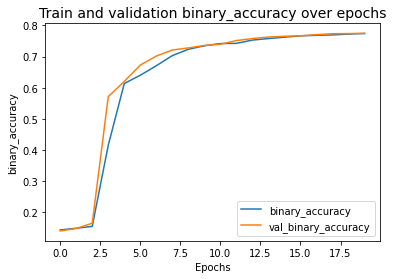

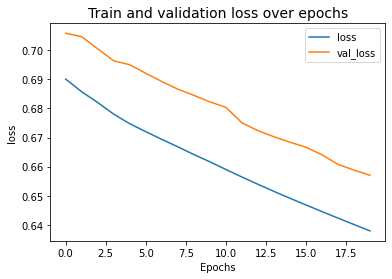

371/371 [==============================] - 1s 2ms/step
Confusion matrixes: 
[[1013  610]
 [2081 8156]]


F1 score: 0.8584

Accuracy score: 0.7731

Recall score: 0.7967


In [48]:
# Training
evaluate_training(history2)

# Testing
test_loss, test_acc = model.evaluate(X_test2, y_test2)
prediction = model.predict(X_test2)
evaluate_testing(y_test2, prediction.round())

In [52]:
combine = np.concatenate((X_test_visualize2, prediction.round()), axis=1)
visualize_result = pd.DataFrame(combine, columns=["x", "y", "z", "accepted"])
visualize_area(visualize_result)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 9383 and the array at index 1 has size 11860

In [54]:
print(X_test2.shape)
print(X_test_visualize.shape)

(9383, 327)
(14162, 3)


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction)

# Using recall and precision at thresholds for optimal f2 scores
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# Re-evaluate
alt_threshold_prediction = np.where(prediction > thresholds[ix], 1, 0)
evaluate_testing(y_test, alt_threshold_prediction)

In [ ]:
# Using recall and precision at thresholds to find the middle ground for both
plt.plot(thresholds, precision[0:-1], label="Precision")
plt.plot(thresholds, recall[0:-1], label="Recall")
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.legend()
plt.title("Precision and recall at thresholds", fontsize=14)
plt.show()

In [ ]:
# Visualize data
alt_threshold_prediction = np.where(prediction > 0.5, 1, 0)
combine = np.concatenate((X_vis2, alt_threshold_prediction), axis=1)
visualize_result = pd.DataFrame(combine, columns=["x", "y", "z", "accepted"])
visualize_area(visualize_result, voxel_size=0.01)

In [ ]:
visualize_area(data_area)

# Increase data

In [ ]:
xStart = np.min(data.x)+0 # Start meter x
yStart = np.min(data.y)+0 # Start meter y
area = 35
data_area = area_of_dataframe(data, xStart, xStart+area, yStart, yStart+area)

cells_in_x = np.arange(data_area.x.min(), data_area.x.max()+CELL_SIZE, CELL_SIZE)
cells_in_y = np.arange(data_area.y.min(), data_area.y.max()+CELL_SIZE, CELL_SIZE)
cells = dataframe_to_normalized_stats_cells(data_area, cells_in_x, cells_in_y, np.array(data), Z_INDEX)

## Own cell

In [ ]:
num_neighbors = 0
neighbors = get_cell_neighbors(cells, cells_in_y, num_neighbors, len(STATISTICS))
processed_data = np.concatenate(neighbors)

X = processed_data[:, Z_INDEX:]
y = processed_data[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Create model
model = keras.Sequential()
model.add(keras.layers.Input(shape=X_train[0].shape, name="Input"))
model.add(keras.layers.Dense(16, activation="relu", name="Hidden1"))
model.add(keras.layers.Dense(1, activation="sigmoid", name="Output"))
model.summary()

opt = keras.optimizers.Adam(0.0001) # learning_rate=1e-6
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, min_delta=0.01, patience=10) # Prevent overfitting

In [ ]:
# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_split=VAL_SPLIT, 
    class_weight=class_weight_dict,
    batch_size=64, # Default
    epochs=20,
    callbacks=[es],
    shuffle=True) # Default

In [ ]:
# Training
evaluate_training(history)

# Testing
test_loss, test_acc = model.evaluate(X_test, y_test)
prediction = model.predict(X_test)
evaluate_testing(y_test, prediction.round())

## Neighbors

In [ ]:
num_neighbors = 2
neighbors = get_cell_neighbors(cells, cells_in_y, num_neighbors, len(STATISTICS))
processed_data = np.concatenate(neighbors)

X = processed_data[:, Z_INDEX:]
y = processed_data[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Create model
model = keras.Sequential()
model.add(keras.layers.Input(shape=X_train[0].shape, name="Input"))
model.add(keras.layers.Dense(128, activation="relu", name="Hidden1"))
model.add(keras.layers.Dense(64, activation="relu", name="Hidden2"))
model.add(keras.layers.Dense(1, activation="sigmoid", name="Output"))
model.summary()

opt = keras.optimizers.Adam(0.000001) # learning_rate=1e-6
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, min_delta=0.01, patience=10) # Prevent overfitting

In [ ]:
# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_split=VAL_SPLIT, 
    class_weight=class_weight_dict,
    batch_size=64, # Default
    epochs=20,
    callbacks=[es],
    shuffle=True) # Default

In [ ]:
# Training
evaluate_training(history)

# Testing
test_loss, test_acc = model.evaluate(X_test, y_test)
prediction = model.predict(X_test)
evaluate_testing(y_test, prediction.round())

## Sampling

In [ ]:
from imblearn.combine import SMOTEENN

sampling = SMOTEENN(sampling_strategy=0.1)
X_train_us, y_train_us = sampling.fit_resample(X_train, y_train)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_us), y=y_train_us)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

In [ ]:
# Create model
model = keras.Sequential()
model.add(keras.layers.Input(shape=X_train[0].shape, name="Input"))
model.add(keras.layers.Dense(128, activation="relu", name="Hidden1"))
model.add(keras.layers.Dense(64, activation="relu", name="Hidden2"))
model.add(keras.layers.Dense(1, activation="sigmoid", name="Output"))
model.summary()

opt = keras.optimizers.Adam(learning_rate=0.000001) # learning_rate=1e-6
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, min_delta=0.01, patience=10) # Prevent overfitting

In [ ]:
# Train the model
history = model.fit(
    X_train_us, 
    y_train_us, 
    validation_split=VAL_SPLIT, 
    class_weight=class_weight_dict,
    batch_size=64, # Default
    epochs=20,
    callbacks=[es],
    shuffle=True) # Default

In [ ]:
# Training
evaluate_training(history)

# Testing
test_loss, test_acc = model.evaluate(X_test, y_test)
prediction = model.predict(X_test)
evaluate_testing(y_test, prediction.round())

In [ ]:
# Create model
SHAPE = (1, 200)

model = keras.Sequential()
model.add(keras.layers.Input(shape=SHAPE, name="Input"))
model.add(keras.layers.Dense(512, activation="relu", name="Hidden1"))
model.add(keras.layers.Dense(1024, activation="relu", name="Hidden2"))
model.add(keras.layers.Dense(512, activation="relu", name="Hidden3"))
model.add(keras.layers.Dense(256, activation="relu", name="Hidden4"))
model.add(keras.layers.Dense(128, activation="relu", name="Hidden5"))
model.add(keras.layers.Dense(1, activation="sigmoid", name="Output"))
model.summary()

## Small cross validation sample

## Small sample
- Underfit
- Overfit
- Perfect